Author: Gordon Erlebacher
Date: 2020-01-10

We will compute a loss surface based on fitting some surface with a neural network using Pytorch

In [1]:
import torch
import numpy as np
from IPython import embed
import matplotlib.pyplot as plt
%matplotlib inline

Create a Gaussian process with a small amount of training points. 
This makes it easy to generate a nonlinear function. 
I will evaluate this function at 10,000 points, that I will store for later use. 
These points will be used for both training and testing in the experiments below. Ss

In [2]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [3]:
np.random.seed(1) 

def f(x):
    "A function to predict"
    return x*np.sin(x)

#X = [1., 3., 5., 6., 7.] # create 2D array shape: [1,n]
X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T  # shape: 2D
Y = f(X).ravel()  # shape 1D

# data
n = 1000

# Compute random values of x
#  why would choosing x as random numbers mess things up? 
# When predicting the GP, the order of points should be irrelevant
x = 10*np.random.uniform(size=n)

# Sort x, or else the plotting will not work
#print("x unsorted: ", x[0:10], len(x))
x.sort()  
x_test = x.reshape(-1,1)  # shape 2D
#print("x sorted: ", x[0:10], len(x))

# Instantiate a Gaussian Process
kernel = C(1., (1.e-3,1.e3)) * RBF(10, (1.e-2, 1.e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit Gaussian Process (careful with array shape)
gp.fit(X, Y)

# Compute GP at n points. Y_pred: shape 1D
y_pred, sigma = gp.predict(x_test, return_std=True)

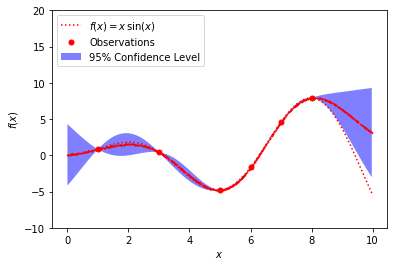

In [4]:
# Plot the Gaussian Process
# Use subplots() so that figure does not disappear when rerunning the cell
# See https://github.com/matplotlib/jupyter-matplotlib/issues/60
fig, ax = plt.subplots()
ax.plot(x, f(x), 'r:', label=r'$f(x)=x\,\sin(x)$')
ax.plot(X, Y, 'r.', markersize=10, label='Observations')
ax.plot(x, y_pred, 'r.', markersize=1)
xpoly = np.concatenate([x, x[::-1]])
ypoly = np.concatenate([y_pred-1.96*sigma, (y_pred+1.96*sigma)[::-1]])
ax.fill(xpoly, ypoly, alpha=.5, fc='b', 
         ec='None', label='95% Confidence Level')
ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')
ax.set_ylim(-10,20)
ax.legend(loc='upper left')
plt.show()

In [5]:
# From Nathan Crock
class P():
    def __init__(self, m, s):
        self.m = m # Slope of line
        self.s = s # Standard deviation of injected noise
    def sample(self, size):
        x = np.random.uniform(size=size)
        y = []
        for xi in x:
            y.append(np.random.normal(self.m*xi, self.s))
        return(x, y)
        

In [6]:
m = 2.7
s = 0.2
p = P(m,s)
x,y = p.sample(20)

Construct a Neural network to do regression using Pytorch

First create the data for training

In [7]:
# Make sure I can execute every cell multiple times in a row. Sometimes, 
# if one reuses a variable defined in an earlier cell, variables can be overwritten
# which can lead to problems. 

from sklearn.model_selection import train_test_split
# The test+train dataset was created using a Gaussian Process
xdata = torch.tensor(x_test)  # (n, 1)
#print(xdata[0:20]) ; 
ydata = torch.tensor(y_pred.copy()).reshape(-1,1) # (n,)
#print(xdata)

train_size = .01
# Data is shuffled by default
xtrain, xtest, ytrain, ytest = train_test_split(xdata.numpy(), ydata.numpy(), train_size=train_size)

#x_train = torch.tensor(x_train, dtype=torch.float)
xtrain = torch.from_numpy(xtrain).float()
xtest = torch.from_numpy(xtest).float()
ytrain = torch.from_numpy(ytrain).float()
ytest = torch.from_numpy(ytest).float()
#print(type(xtrain))
xtrain = xtrain.reshape(-1,1)
ytrain = ytrain.reshape(-1,1)
#print(xtrain.shape, ytrain.shape);

/home/ndc08/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [8]:
from torch.autograd import Variable
import torch.nn as nn

In [9]:
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, hiddenSize, outputSize):
        super(linearRegression, self).__init__()
        self.input_linear1 = torch.nn.Linear(inputSize, hiddenSize)
        self.input_linear2 = torch.nn.Linear(hiddenSize, outputSize)
        self.sigmoid = nn.Tanh()
 
    def forward(self, x):
        x = self.input_linear1(x)
        x = self.sigmoid(x)  # I should be able to drive loss to zero
        x = self.input_linear2(x)
        return x

In [10]:
inputDim = 1
hiddenDim = 10
outputDim = 1
learningRate = .1
epochs = 500
model = linearRegression(inputDim, hiddenDim, outputDim)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
#print(model.state_dict())

In [11]:
losses = []
for epoch in range(epochs):
    # Converting inputs and labels to Variable
    if torch.cuda.is_available():
        inputs = Variable(xtrain)
        labels = Variable(ytrain)
    else:
        inputs = Variable(xtrain)
        labels = Variable(ytrain)

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    model.train()
    outputs = model(inputs)

    # get loss for the predicted output
    loss = criterion(outputs, labels)
    losses.append(loss.item())
    #print(loss.item(), epoch)
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()

    #print('epoch {}, loss {}'.format(epoch, loss.item()))
    
#print(model.state_dict())
#print("--------------------")




<Figure size 432x288 with 0 Axes>

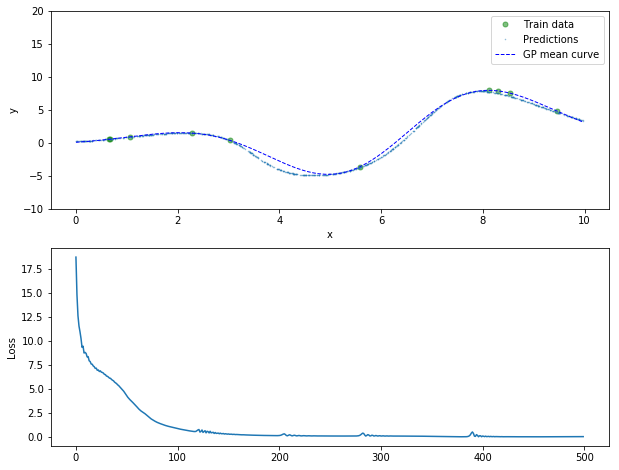

train_data len:  10
test_data len:  990


In [12]:
# test the model

with torch.no_grad():
    predicted = model(Variable(xtest))
    
    
plt.clf()
fig, axes = plt.subplots(2,1, figsize=(10,8))
ax = axes[0]
ax.plot(xtrain, ytrain, 'go', markersize=5, label='Train data', alpha=0.5)
ax.plot(xtest, predicted, '.', markersize=1, label='Predictions', alpha=0.5)
# plot base curve
ax.plot(xdata, ydata, 'b--', lw=1, label='GP mean curve')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(loc='best')
ax.set_ylim(-10,20)

ax = axes[1]
xl = np.linspace(0, len(losses)-1, len(losses))
ax.plot(xl, losses)
ax.set_ylabel('Loss')
plt.show()
#print(losses)
print("train_data len: ", len(xtrain))
print("test_data len: ", len(xtest))
